In [169]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

.. _LFW: http://vis-www.cs.umass.edu/lfw/

Expected results for the top 5 most represented people in the dataset:

================== ============ ======= ========== =======
                   precision    recall  f1-score   support
================== ============ ======= ========== =======
     Ariel Sharon       0.67      0.92      0.77        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.86      0.86      0.86       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322
================== ============ ======= ========== =======



In [170]:
#Yuri Carlos Bonifácio Neves - 1609670

# Projeto 03 - Reconhecimento de Faces para a disciplina de Reconhecimento de Padrões em Imagens (2017/1)

#
#   O presente trabalho procura classificar as faces de identidades famosas
#por meio de eigen faces, tendo suas dimensionalidades reduzidas a partir
#do algoritmo PCA e, posteriormente, classificadas utilizando 5 classificadores,
#sendo eles:
#   DecisionTree, Knn, Naive Bayes, LDA e SVM
#
#   Primeiramente é executado uma otimização na escolha dos parâmetros para cada um 
#dos classificadores por meio do GridSearchCv. As melhores escolhas são usadas no 
#processo de treino e classificação, e estão discriminadas a baixo 
#   Após este processo, é executado o PCA, a fim de reduzir a dimensionalidade das
#eigenFaces.
#   Como os classificadores são diferentes e possuem características de funcionamento
#diferentes é executado uma busca a fim de encontrar qual o melhor número de 
#componentes para cada um destes classificadores. Os valores selecionados foram:

#   DecisionTree - 45
#   Naive Bayes  - 75
#   Knn          - 65
#   LDA          - 80
#   SVM          - 80

#   Então é feita a classificação com cada um dos classificadores com os parâmetros
#e valores de componentes obitidos.

#   Foi usada uma divisão de 75% dos dados para treino e 25% para teste.

#   O Decision Tree foi o classificador com o pior resultado, como já era de se esperar,
#uma vez que os dados são pouco categóricos. Seus resultados médios foram:
#                  precision    recall      f1         support
#                  0.53         0.52        0.52       322

#   No Naive Bayes, por não possuir uma grande quantidade de parâmetros, a fim de 
#otimizar os resultados, foi definido como prior as proporções de cada classe,
#ou seja, razão entre a quantidade de amostras que uma classe possuia e a quantidade
#de amostras total. Aparentemente a definição de priors dessa maneira não foi
#muito eficiente, já que não influenciou muito nos resultados.

#Antes de se definir as priors
#                 precision    recall      f1         support
#                 0.78         0.77        0.76       322

#Depois de se definir as priors
#                 precision    recall      f1         support
#                 0.77         0.75        0.75       322

#   O Knn seguiu com resultados não muito bons. Suspeito que seja devido ao número
#de amostras. possivelmente, se tivessemos mais amostras o Knn teria um melhor 
#desempenho. Segue os resultados:

#                 precision    recall      f1         support
#                 0.72         0.72        0.71       322

#   LDA teve resultados muito bons, bem próximos do SVM. Infelizmente, mesmo após 
#o processo do LDA, as classes ainda ficam meio misturadas, provavel que por este
#motivo os resultados não sejam melhores.
#   Em termos de carga computacional, por sua proximidade de resultados com o SVM,
#pode ser uma boa opção escolher usar o LDA em uma aplicação como essa em vez 
#do SVM.

#                 precision    recall      f1         support
#                 0.80         0.80        0.80       322

#   O SVM obteve os melhores resultados, sendo eles:

#                 precision    recall      f1         support
#                 0.87         0.86        0.86       322

from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt


import numpy as np 
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


#vetor de classificadores
clfss = []

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


Download the data, if not already on disk and load it as numpy arrays


In [171]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]


# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

2017-05-29 10:09:01,536 Loading LFW people faces from /home/yuricarlos/scikit_learn_data/lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Split into a training set and a test set using a stratified k fold


In [172]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [173]:
n_components = 100

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

done in 0.255s


Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction


Extracting the top 100 eigenfaces from 966 faces
done in 0.233s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.027s


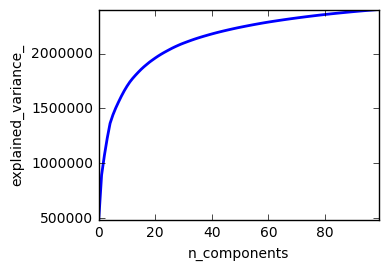

In [174]:
n_components = 100

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(np.cumsum(pca.explained_variance_), linewidth=2)
    
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [175]:
from sklearn.tree import DecisionTreeClassifier

#Decision Tree
#
# param_grid para a GridSearchCV:
#param_grid = {'max_depth': [10, 25, 50, 75, 100, 150, 200, 400],
#              'criterion': ['gini', 'entropy'],
#              'max_features': ['auto', 'sqrt', 'log2', None],
#              'class_weight': ['balanced', None]
#              }
#clf = GridSearchCV(DecisionTreeClassifier(), param_grid)
#clf = clf.fit(X_train_pca, y_train)
#print(clf.best_estimator_)

#melhor escolha
clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=400,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

clfss.append(clf)


In [176]:
#Naive Bayes
#
#pega a proporção de cada classe pra usar como prior no naive Bayes
proportion = []
parent_path = 'lfw_funneled'

for name in target_names:
    proportion.append(float(len(os.listdir(('lfw_funneled/'+ name).replace(' ', '_')))) / float(n_samples) )
    
#print('Proporções de cada classe ', proportion)

#executa o naive bayes
from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB(priors = proportion)
clf = GaussianNB()

clfss.append(clf)


In [177]:
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier
#
#param_grid para a GridSearchCV:
#param_grid = {'n_neighbors': [2, 4, 5, 6, 8, 20, 50, 100, 200, 400],
#              'algorithm': ['brute', 'ball_tree', 'kd_tree'],
#              'weights': ['uniform', 'distance']}
#clf = GridSearchCV(KNeighborsClassifier(), param_grid)

#clf = clf.fit(X_train_pca, y_train)
#print(clf.best_estimator_)

#resultado da melhor escolha
clf = KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

clfss.append(clf)

In [178]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
#
#
#param_grid = {'solver': ['svd', 'lsqr', 'eigen']}
#
#clf = GridSearchCV(LDA(), param_grid)
#clf = clf.fit(X_train_pca, y_train)
#print(clf.best_estimator_)

#clf = clf.fit(X_train_pca, y_train)
#y_pred = clf.predict(X_test_pca)
#analyzeFeaturesLDA(X_test_pca, y_test, clf)


#resultado da melhor escolha
clf = LDA(n_components=None, priors=None, shrinkage=None,solver='svd', store_covariance=False, tol=0.0001)
clfss.append(clf)




Train a SVM classification model


In [179]:
# SVM

#
#print("Fitting the classifier to the training set")
#t0 = time()
#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
#clf = clf.fit(X_train_pca, y_train)
#print("done in %0.3fs" % (time() - t0))
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)

#resultado selecionado
#SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
#  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
#  max_iter=-1, probability=False, random_state=None, shrinking=True,
#  tol=0.001, verbose=False)

clf = SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

clfss.append(clf)


#clf = clf.fit(X_train_pca, y_train)



Quantitative evaluation of the model quality on the test set


In [180]:




def train_classifiersPCA(classifiers, train, test):
    
    print(len(classifiers))
    bestNC = []
    print("================================================")
    print("medindo componentes")
    print("================================================")
    #mede o melhor numero de componentes de cada classificador
    for clf in classifiers: 
        #n componentes
        n_components_array=[20, 30, 45, 55, 65,75,80,85,100]
        score_array = np.zeros(len(n_components_array))
        i=0

        # Mede o melhor numero de componentes
        for n_components in n_components_array:
            pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(train)
            
            transformTrain = pca.transform(train)
            transformTest = pca.transform(test)
            
            clf.fit(transformTrain, y_train)
            #mede seu score
            score_array[i] = clf.score(transformTest, y_test)
            i=i+1
        #seleciona o melhor numero de componentes dentre as opcoes
        bestNC.append(n_components_array[score_array.argmax(axis=0)])        
        
    print("================================================")
    print("treinando classificadores")
    print("================================================")
    #treina os classificadores com os valores encontrados
    for idx, clf in enumerate(classifiers):
        #roda o PCA
        pca = PCA(n_components=bestNC[idx], svd_solver='randomized', whiten=True).fit(train)
        #treina o classificador
        transformTrain = pca.transform(train)
        transformTest = pca.transform(test)
        
        clf.fit(transformTrain, y_train)
        
        #prediz
        print("================================================")
        #plt.xlabel("Predição classificador " + clf.__class__.__name__, size=20)
        print("Predição classificador " + clf.__class__.__name__)
        print("================================================")
        
        t0 = time()
        y_pred = clf.predict(transformTest)
        print("done in %0.3fs" % (time() - t0))

        print(classification_report(y_test, y_pred, target_names=target_names))
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
            

    print("bestNC:")
    print(bestNC)        
    return bestNC

train_classifiersPCA(clfss, X_train, X_test)

5
medindo componentes
treinando classificadores
Predição classificador DecisionTreeClassifier
done in 0.000s
                   precision    recall  f1-score   support

     Ariel Sharon       0.25      0.38      0.30        13
     Colin Powell       0.50      0.37      0.42        60
  Donald Rumsfeld       0.26      0.33      0.30        27
    George W Bush       0.73      0.64      0.68       146
Gerhard Schroeder       0.22      0.24      0.23        25
      Hugo Chavez       0.23      0.40      0.29        15
       Tony Blair       0.31      0.36      0.33        36

      avg / total       0.52      0.48      0.49       322

[[ 5  5  1  2  0  0  0]
 [ 6 22  2 14  5  0 11]
 [ 4  1  9  7  3  1  2]
 [ 4 10 13 94  5 12  8]
 [ 1  2  5  3  6  3  5]
 [ 0  1  0  3  2  6  3]
 [ 0  3  4  6  6  4 13]]
Predição classificador GaussianNB
done in 0.002s
                   precision    recall  f1-score   support

     Ariel Sharon       0.54      1.00      0.70        13
     Colin Powell   

[45, 75, 80, 75, 85]

In [181]:
def variancePCA(train, target):
    
    pca = PCA(n_components=train.shape[1])
    pca.fit(train)
        
    plt.figure(1, figsize=(4, 3))
    plt.clf()
    plt.axes([.2, .2, .7, .7])
    plt.plot(np.cumsum(pca.explained_variance_), linewidth=2)
    
    plt.axis('tight')
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_')

Qualitative evaluation of the predictions using matplotlib


In [182]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

#prediction_titles = [title(y_pred, y_test, target_names, i)
#                     for i in range(y_pred.shape[0])]

#plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

#eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
#plot_gallery(eigenfaces, eigenface_titles, h, w)

#plt.show()

In [183]:
def analyzeFeaturesLDA(train, target, lda):
    
    # Taking in as second argument the Target as labels
    lda = LDA(n_components=2)
    transform = lda.fit_transform(train, target)
    
    plt.figure(figsize=(6,5))
    plt.scatter(transform[:,0],transform[:,1], s=20, c = target, cmap = "nipy_spectral", edgecolor = "None")
    plt.colorbar()
    plt.clim(0,9)
